# PyGEM Advanced Test - Dynamical Spinup and 1D Elevation Change Calibration

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
Created: 04OCT2025<br> <br>
Objective: build on the [*advanced_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test.ipynb) demonstration and goes over running inversion and dynamical spinup, followed by calibration and simulation. This advanced calibration notebook demonstrates MCMC calibration against both geodetic mass balance data and 1D elevation change observations (processed from [Hugonnet et al. 2021](https://doi.org/10.1038/s41586-021-03436-z) data in the [*dhdt_processing.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/dhdt_processing.ipynb)). If you have yet to do so, we suggest going through the advanced test notebook in full before proceeding.<br>

This demonstration utilizes PyGEM's *sample_data* for Gulkana Glacier (RGI60-01.00570), which should have been downloaded during model installation and setup (see [here](https://pygem.readthedocs.io/en/latest/install_pygem.html)), but can also be downloaded directly [here](https://drive.google.com/file/d/1Wu4ZqpOKxnc4EYhcRHQbwGq95FoOxMfZ/view?usp=drive_link).<br>

Tasks:
1. Run inversion
2. Run calibration - emulator (optional)
3. Run dynamical spinup
4. Run calibration
5. Run simulations

> **📝 Note:**<br>
> In this notebook, any PyGEM Python scripts that are called will be preceeded by ```!```. In Jupyter Notebook, the ```!``` character is used to execute shell commands directly from a notebook cell. When you prefix a command with ```!```, Jupyter sends it to the system's command-line shell for execution, instead of interpreting it as Python code. Command-line arguments are also bracketed (e.g., ```{arg}```), when passing Python variables to a command-line shell from within a Jupyter Notebook. If executing a given PyGEM script directly from one's terminal, remove the ```!``` character and brackets ```{}``` around arguments.
>

> **⚠️ Warning:**<br>
> Ensure that the `root` parameter in PyGEM configuration file points to the correct path for the sample dataset (should end in */sample_data/*, not */sample_data_tw/*):<br>

In [1]:
%%bash
grep 'root:' ~/PyGEM/config.yaml

root: /Users/btober/PyGEM/sample_data/sample_data # note, this parameter must be modfied as to point to the appropriate location. all other paths are assumed relative to this (inputs and outputs).


If the incorrect path is set, you may manually modify with the text editor of your choice so that the `root` parameter is set to point to wherever the appropriate sample dataset is located on your computer.<br>

In [2]:
### imports ###
import os, sys, glob, json
from oggm import cfg, tasks, workflow
from IPython.display import Image, display
# pygem imports
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.
# get root path
rootpath = pygem_prms["root"]
# reduce oggm logging level to keep notebook clean
config_manager.update_config(updates={'oggm.logging_level' : 'CRITICAL'})

## 1. Ice thickness inversion

In order to run dynamical spinup, we will need the output from first running ice thickness inversion. This would typically be performed using a regionally-calibrated Glen's A ice creep value. See [*run_inversion.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_inversion.ipynb) for more information. Here we'll run inversion for a single glacier of interest using previously calibrated regional Glen's A values.<br><br>
What are the options of PyGEM's *run_inversion* script?

In [3]:
!run_inversion -h

usage: run_inversion [-h] [-rgi_region01 RGI_REGION01 [RGI_REGION01 ...]]
                     [-rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]]
                     [-rgi_glac_number_fn RGI_GLAC_NUMBER_FN]
                     [-calibrate_regional_glen_a CALIBRATE_REGIONAL_GLEN_A]
                     [-glen_a GLEN_A] [-fs FS] [-ncores NCORES]
                     [-outpath OUTPATH] [-reset_gdirs] [-v]

Perform glacier bed inversion (defaults to finding best Glen's A for each RGI
order 01 region)

options:
  -h, --help            show this help message and exit
  -rgi_region01 RGI_REGION01 [RGI_REGION01 ...]
                        Randoph Glacier Inventory region (can take multiple,
                        e.g. `-run_region01 1 2 3`)
  -rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]
                        Randoph Glacier Inventory glacier number (can take
                        multiple)
  -rgi_glac_number_fn RGI_GLAC_NUMBER_FN
                        Filepath contain

We'll run inversion with the following arguments:
<pre>
glac_no =                       1.00570
calibrate_regional_glen_a =     False
</pre>

We first need to set `setup.rgi_region01=None` in our confiuration file (or comment out any list items following `setup.rgi_region01`).

In [4]:
# update the rgi_region01 key as described above
config_manager.update_config(updates={'setup.rgi_region01' : None})

In [5]:
glac_no = 1.00570
!run_inversion -rgi_glac_number {glac_no} -calibrate_regional_glen_a False

1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
Traceback (most recent call last):
  File "/Users/btober/miniconda3/envs/pygem-test/bin/run_inversion", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/btober/Documents/tmp/PyGEM/pygem/bin/run/run_inversion.py", line 486, in main
    run_partial(batch)
  File "/Users/btober/Documents/tmp/PyGEM/pygem/bin/run/run_inversion.py", line 370, in run
    raise ValueError(
ValueError: Only set up to export regional Glen A parameters if regionally calibrated against the regional ice volume estimate.


## 2. Mass balance emulator calibration

In order to perform dynamical spinup, we'll calibrate against mass balance observations.

<pre>
glac_no =               1.00570
ref_startyear =         2000
ref_endyear =           2019
option_calibration =    emulator   
</pre>

In [6]:
!run_calibration -rgi_glac_number {glac_no} -option_calibration emulator -ref_startyear 2000 -ref_endyear 2019

Processing: ERA5
1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
ERA5 : RGI60-01.00570
Total processing time: 6.745664834976196 s


## 3. Dynamical spinup

We'll now run dynamical spinup, seeking to match the glacier area given by the Randolph Glacier Inventory.<br><br>
What are the options of PyGEM's *run_spinup* script?

In [7]:
!run_spinup -h

usage: run_spinup [-h] [-rgi_region01 RGI_REGION01 [RGI_REGION01 ...]]
                  [-rgi_region02 RGI_REGION02 [RGI_REGION02 ...]]
                  [-rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]]
                  [-rgi_glac_number_fn RGI_GLAC_NUMBER_FN]
                  [-target_yr TARGET_YR] [-ye YE] [-ncores NCORES]
                  [-mb_model_params {regional_priors,emulator}]
                  [-spinup_period SPINUP_PERIOD | -optimize]
                  [-periods2try PERIODS2TRY [PERIODS2TRY ...]]
                  [-outdir OUTDIR] [-v]

perform dynamical spinup

options:
  -h, --help            show this help message and exit
  -rgi_region01 RGI_REGION01 [RGI_REGION01 ...]
                        Randoph Glacier Inventory region (can take multiple,
                        e.g. `-run_region01 1 2 3`)
  -rgi_region02 RGI_REGION02 [RGI_REGION02 ...]
                        Randoph Glacier Inventory subregion (either `all` or
                        multiple spaced 

We'll run spinup with the following arguments:
<pre>
glac_no =           1.00570
mb_model_params =   emulator   
</pre>

In [8]:
!run_spinup -rgi_glac_number {glac_no} -mb_model_params emulator

Processing with 1 cores... 
[['01.00570']]
1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]


If successful, the script will run without errors and the following datasets will be generated:

* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00/RGI60-01.00570/diagnostics.json*<br>
* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00/RGI60-01.00570/model_diagnostics_dynamic_spinup_pygem_mb.nc*<br>
* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00/RGI60-01.00570/model_geometry_dynamic_spinup_pygem_mb.nc*<br>
* *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00/RGI60-01.00570/fl_diagnostics_dynamic_spinup_pygem_mb.nc*<br>

The key file PyGEM will use for next running calibration and simulations is *~sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00/RGI60-01.00570/model_geometry_dynamic_spinup_pygem_mb.nc*, which contains the model geometry for each year of dynamical spinup. We can also check OGGM's log file for a successful spinup run:

In [9]:
# get glacier string and region
glac_str = f"{glac_no:.{5}f}"
reg = glac_str.split('.')[0].zfill(2)

In [10]:
%%bash -s "$rootpath" "$reg" "$glac_str"
sfix="${3#*.}"
thous="${sfix:0:2}"
ls -lRah $1/oggm_gdirs/per_glacier/RGI60-$2/RGI60-$2.$thous/
tail -1 $1/oggm_gdirs/per_glacier/RGI60-$2/RGI60-$2.$thous/RGI60-$2.$sfix/log.txt


total 0
drwxr-xr-x   3 btober  staff    96B Nov  4 12:29 .
drwxr-xr-x   3 btober  staff    96B Nov  4 12:29 ..
drwxr-xr-x  25 btober  staff   800B Nov  4 12:29 RGI60-01.00570

/Users/btober/PyGEM/sample_data/sample_data/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00//RGI60-01.00570:
total 6328
drwxr-xr-x  25 btober  staff   800B Nov  4 12:29 .
drwxr-xr-x   3 btober  staff    96B Nov  4 12:29 ..
-rw-r--r--@  1 btober  staff    40K Nov  4 12:29 climate_historical.nc
-rw-r--r--@  1 btober  staff   259K Nov  4 12:29 debris_ed.tif
-rw-r--r--@  1 btober  staff   259K Nov  4 12:29 debris_hd.tif
-rw-r--r--   1 btober  staff   259K Nov  4 12:29 dem.tif
-rw-r--r--   1 btober  staff   527B Nov  4 12:29 dem_source.txt
-rw-r--r--@  1 btober  staff   633B Nov  4 12:29 diagnostics.json
-rw-r--r--   1 btober  staff   2.0K Nov  4 12:29 downstream_line.pkl
-rw-r--r--@  1 btober  staff   1.5K Nov  4 12:29 elev_change_1d.json
-rw-r--r--@  1 btober  staff   3.9K Nov  4 12:29 elevation_band_flowline.csv
-rw-r-

We can also check OGGM's log file for a successful spinup run:

In [11]:
%%bash -s "$rootpath"
tail -1 $1/oggm_gdirs/per_glacier/RGI60-01/RGI60-01.00/RGI60-01.00570/log.txt

2025-11-04T12:29:42;run_dynamic_spinup_dynamic_spinup_pygem_mb;time:0.40805602073669434;SUCCESS


Note, the default `spinup_period` is 20 years, but this parameter can be optimized by minimzing the misfit between modeled and observed elevation change data, if available. See the `-optimize` flag and the `-periods2try` argument. However, to run spinup further back in time, one will need to download more complete ERA5 climate data (the sample dataset only goes back to 1979)

## 4. Run calibration

We'll now run Bayesian inference model calibration against both glacierwide mass balance and 1D elevation change data using the model flowlines from dynamical spinup. We can achieve this with both the `-spinup` and the `-option_calib_elev_change_1d` flags, as shown below:

In [12]:
!run_calibration -h

usage: run_calibration [-h] [-rgi_region01 RGI_REGION01 [RGI_REGION01 ...]]
                       [-rgi_region02 RGI_REGION02 [RGI_REGION02 ...]]
                       [-ref_climate_name REF_CLIMATE_NAME]
                       [-ref_startyear REF_STARTYEAR]
                       [-ref_endyear REF_ENDYEAR]
                       [-rgi_glac_number_fn RGI_GLAC_NUMBER_FN]
                       [-rgi_glac_number RGI_GLAC_NUMBER [RGI_GLAC_NUMBER ...]]
                       [-ncores NCORES]
                       [-option_calibration OPTION_CALIBRATION]
                       [-nchains NCHAINS] [-chain_length CHAIN_LENGTH]
                       [-burn_pct BURN_PCT] [-thin THIN] [-option_ordered]
                       [-option_calib_glacierwide_mb_mwea]
                       [-option_calib_elev_change_1d] [-spinup] [-p] [-v]

Run PyGEM calibration

options:
  -h, --help            show this help message and exit
  -rgi_region01 RGI_REGION01 [RGI_REGION01 ...]
                        R

Running the full dynamical evolution model in MCMC calibration is significantly slower than previously demonstrated MCMC calibration shown in the [*advanced_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test.ipynb) notebook.  Because of this, a very short calibration chain will be run herein (with no thinning). The following parameters should either be set within your configuration file, or passed to the *run_calibration* script as command line arguments:
<pre>
glac_no =                       1.00570
ref_startyear =                 2000
ref_endyear =                   2020    # to include all Hugonnet calibration data
option_calibration =            MCMC
chain_length =                  100
burn_pct =                      20
thin =                          10
option_calib_elev_change_1d =   true
</pre>

In [13]:
# passing the above parameters as command line arguments:
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2020 -option_calibration MCMC -chain_length 200 -burn_pct 20 -thin 10 -spinup -option_calib_elev_change_1d -v  -p # `-v` == vervose (will generate some diagnostic plots) and `-p` == progress bar

Processing: ERA5
1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
ERA5 : RGI60-01.00570
  mb_data (mwea): -0.77 +/- 0.14
1.00570 chain 0 attempt 0 initials:
tbias: 0.28, kp: 1.82, ddfsnow: 0.0041, rhoabl: 900.0, rhoacc: 600.0
210it [00:21,  9.55it/s]                                                        
mb_mwea_mean: -0.627 mb_mwea_std: 0.002 
mb_obs_mean: -0.773 mb_obs_std: 0.145
Figure(600x800)
Figure(300x200)
Figure(500x600)
Figure(300x200)
Total processing time: 23.415376901626587 s


Open some diagnostic plots. These plots are simply intended to serve as diagnostics of the performance of Bayesian inference calibration.<br><br>

The first plot shows the accepted (orange) and proposed (blue) steps across the MCMC sampling chain for each of PyGEM's three model parameters (temperature bias, precipitation factor, and the degree-day factor of snow, respectively for the top three panels). The fourth panel down shows the modeled mass balance across the chain compared to geodetic observations (with 1- and 2$\sigma$ uncertainty shown by the shaded region). The final panel shows the acceptance rate across the chain (accepted v. proposed samples).<br><br>
For further analysis of MCMC calibration, see the [*analyze_mcmc.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/analyze_mcmc.ipynb) notebook.

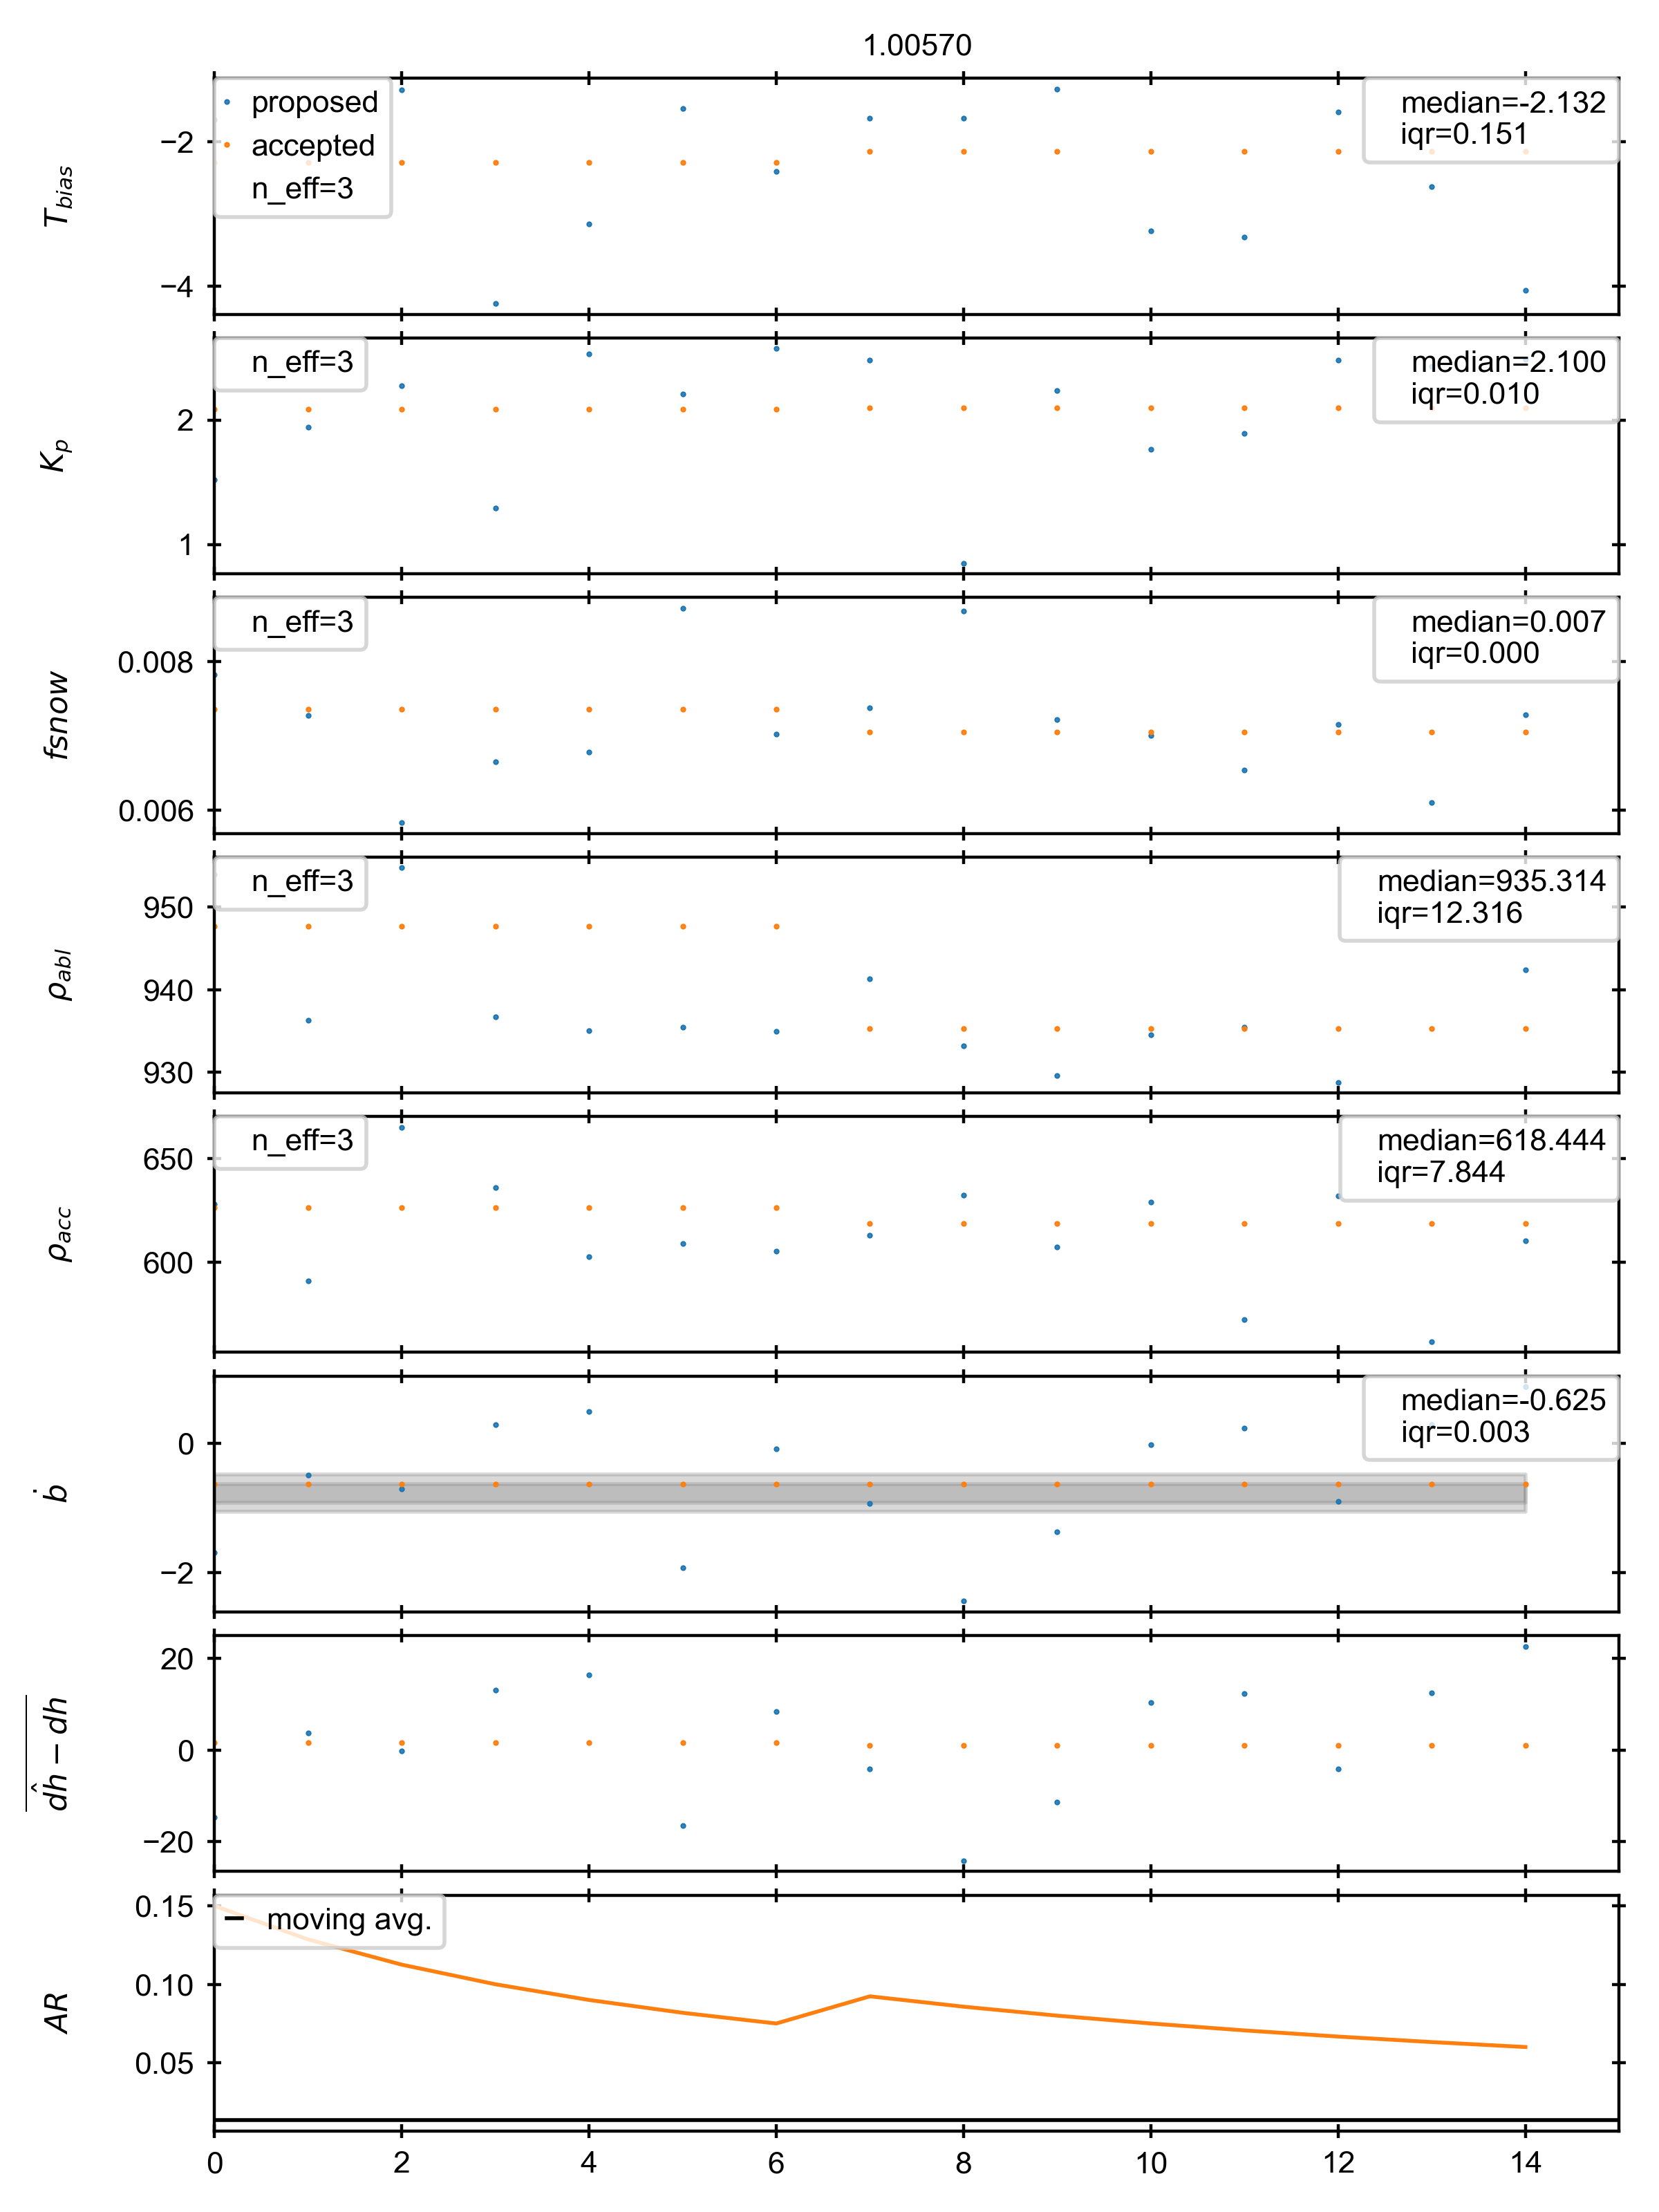

In [14]:
display(Image(filename=f'{rootpath}/Output/calibration/{reg}/fig/dh/{glac_str}-chain0.png', width=500, height=300))

The next plot the predicted v. observed elevation change.

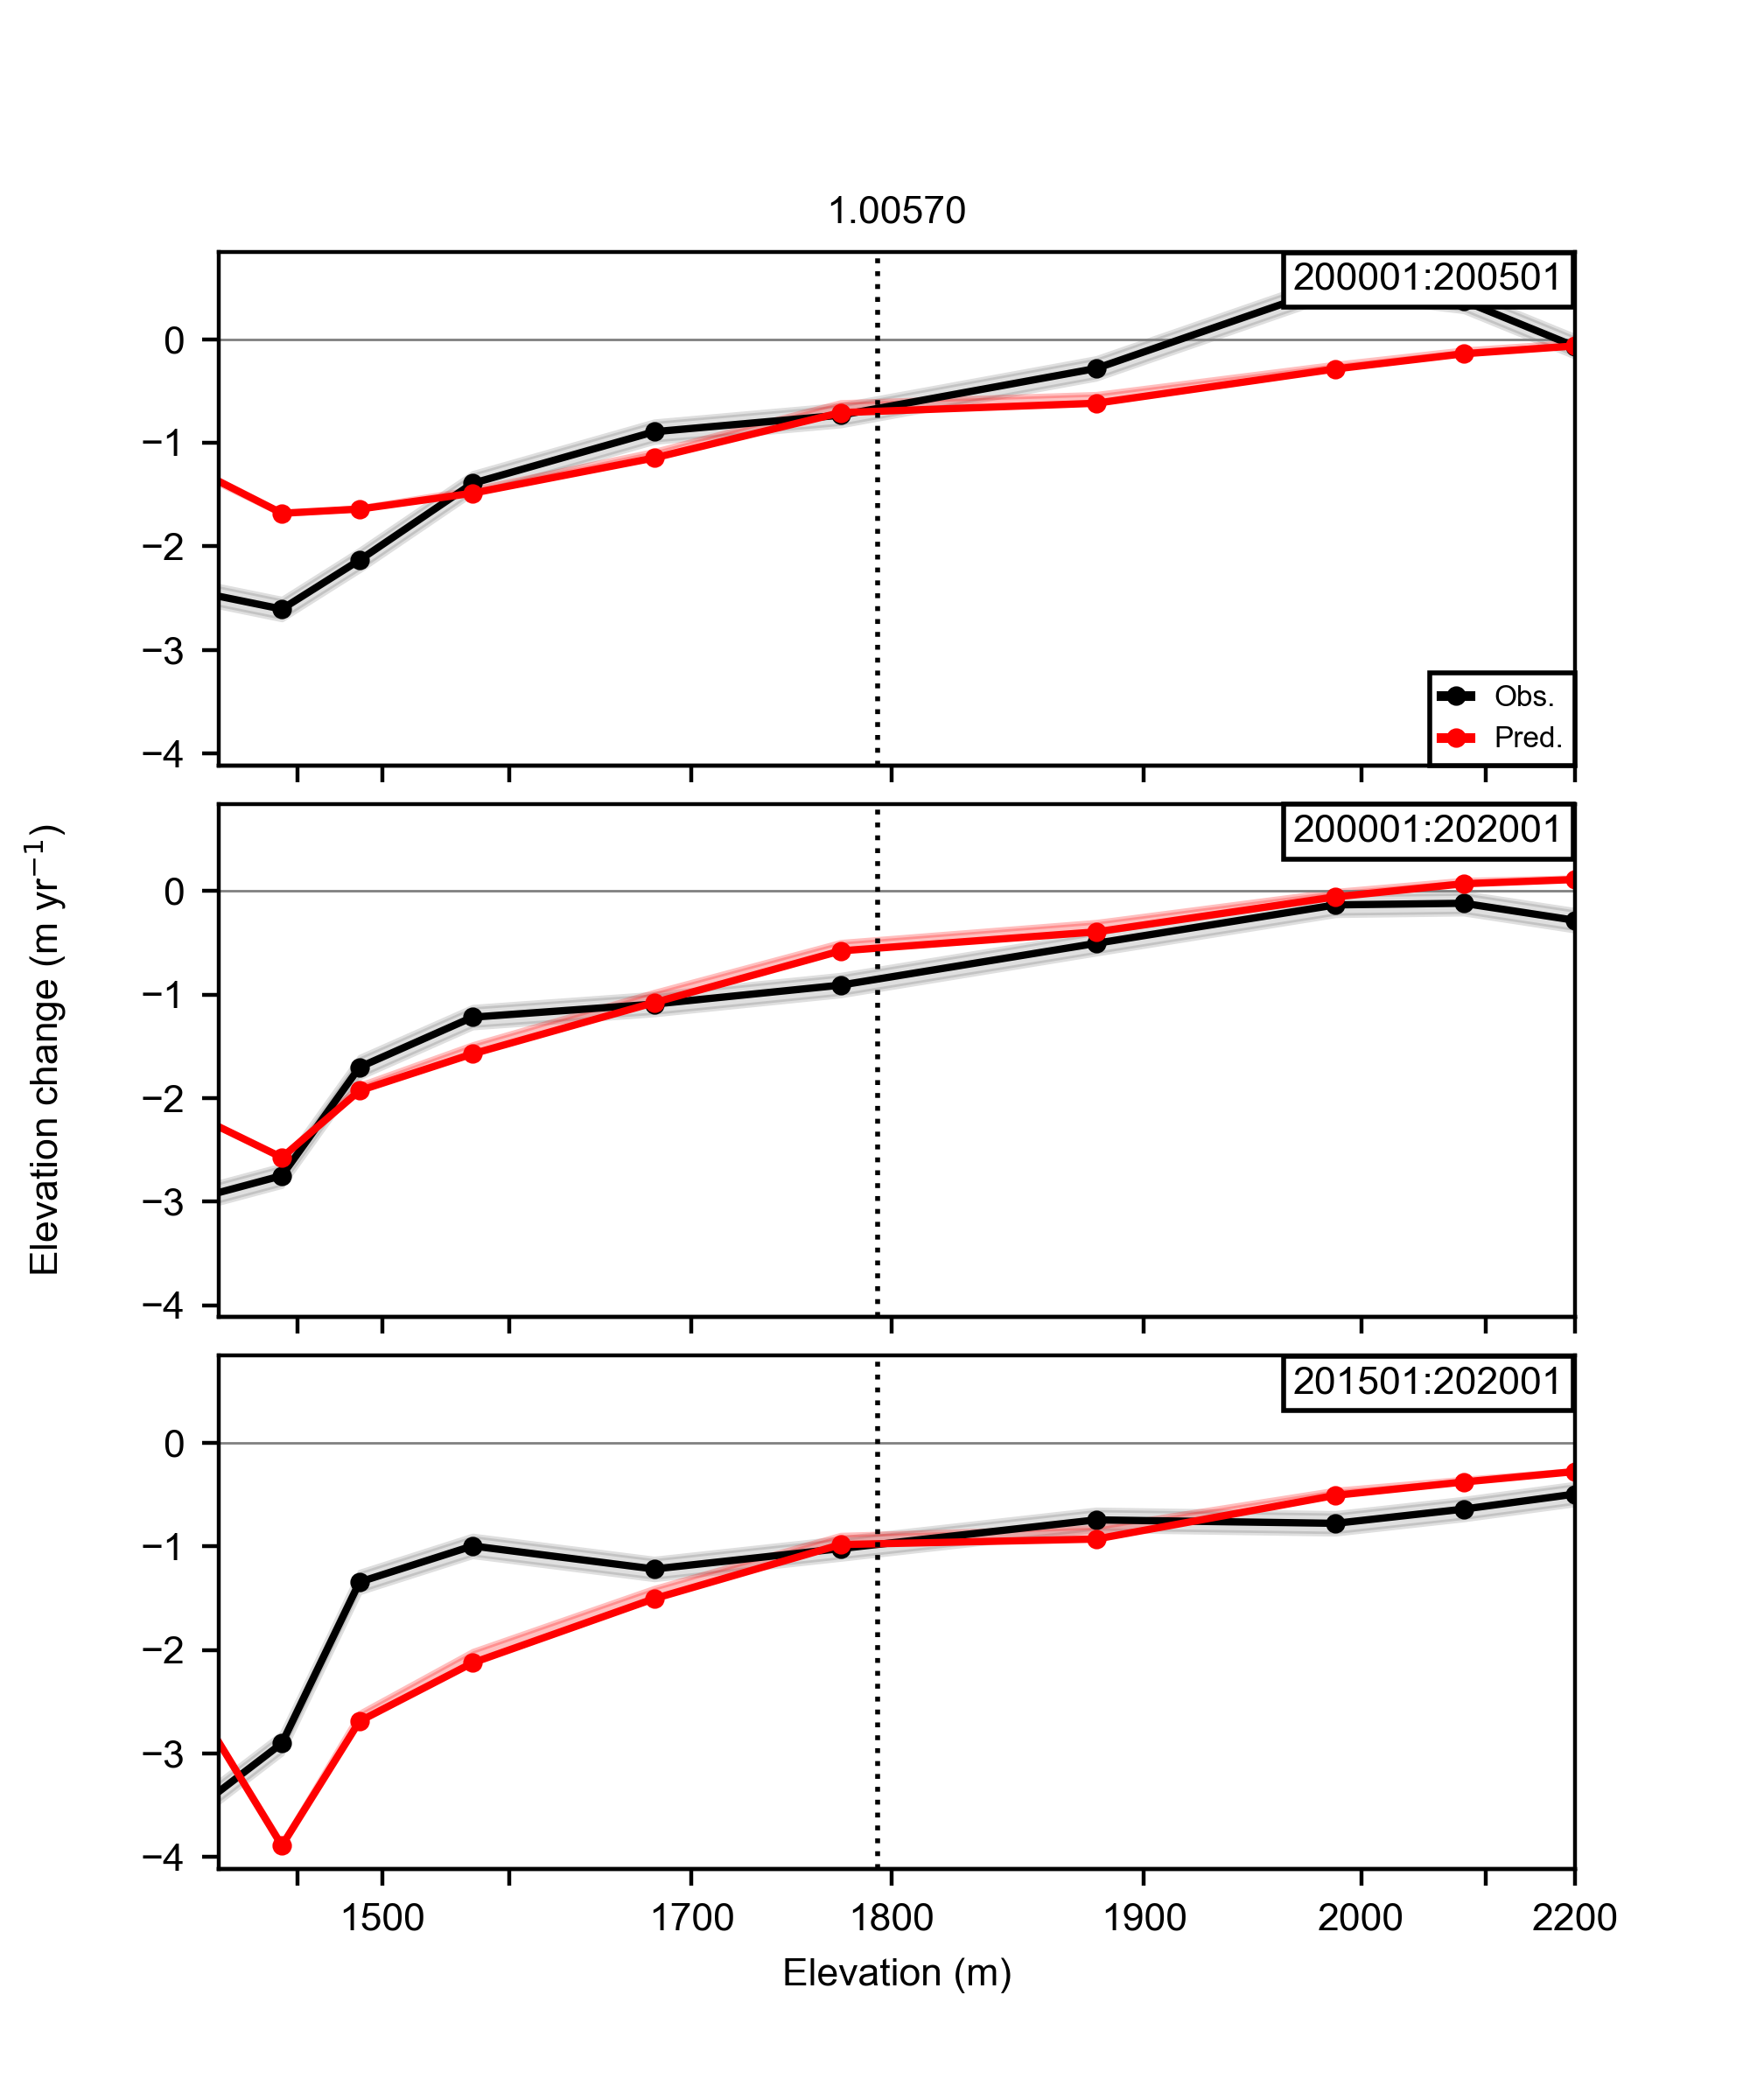

In [15]:
display(Image(filename=f'{rootpath}/Output/calibration/{reg}/fig/dh/{glac_str}-chain0-elev_change_1d.png', width=500, height=300))

Note, these results are from a very short MCMC calibration chain - in practice we've found that a chain length of >= 20k steps is when calibrating against elevation change data.

The ouput model parameter calibration file can be found here:

In [16]:
%%bash -s "$rootpath" "$reg" "$glac_str"
ls -lah $1/Output/calibration/$2/dh/$3*.json

-rw-r--r--@ 1 btober  staff    14K Nov  4 12:30 /Users/btober/PyGEM/sample_data/sample_data/Output/calibration/01/dh/1.00570-modelprms_dict.json


## 5. MCMC simulations

We'll now run future simulations using the model flowlines from dynamical spinup. The following parameters should either be set within your configuration file, or passed to the *run_simulation* script as command line arguments:
<pre>
glac_no =               1.00570
sim_climate_name =      CESM2
sim_climate_scenario =  ssp245
sim_startyear =         2000
sim_endyear =           2100
option_calibration =    MCMC
nsims =                 1
option_dynamics =       OGGM
use_reg_glena =         False         
</pre>

We'll also need to point to the proper parameter calibration file. We can do this with the `-modelprms_fp` command-line argument.

In [17]:
# passing the above parameters as command line arguments:
gcm_name = 'CESM2'
scenario = 'ssp245'
!run_simulation -rgi_glac_number {glac_no} -sim_climate_name {gcm_name} -sim_climate_scenario {scenario} -sim_startyear 2000 -sim_endyear 2100 -option_calibration MCMC -nsims 1 -option_dynamics OGGM -use_regional_glen_a False -spinup -outputfn_sfix spinup_ -modelprms_fp {rootpath}/Output/calibration/{reg}/dh/{glac_str}-modelprms_dict.json

2025-11-04 12:30:12: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-11-04 12:30:12: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-11-04 12:30:12: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-11-04 12:30:13: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2025-11-04 12:30:13: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2025-11-04 12:30:13: oggm.cfg: PARAMS['trapezoid_lambdas'] changed from `2.0` to `1`.
Processing: CESM2 ssp245
Processing with 1 cores...
1 glaciers in region 1 are included in this model run: ['00570']
This study is focusing on 1 glaciers in region [1]
CESM2 : RGI60-01.00570
Total processing time: 0.5928831100463867 s


If successful, we should see the following simulation dataset:

In [18]:
%%bash -s "$rootpath" "$reg" "$gcm_name" "$scenario"
ls -lah $1/Output/simulations/$2/$3/$4/stats/*1set*spinup*.nc

-rw-r--r--@ 1 btober  staff    63K Nov  4 12:30 /Users/btober/PyGEM/sample_data/sample_data/Output/simulations/01/CESM2/ssp245/stats/1.00570_CESM2_ssp245_MCMC_ba1_1sets_2000_2100_spinup_all.nc


## Next:
After calibrating against elevation change data, one may want to compare the resulting simulations with those from calibration upon glacierwide mass balance data alone.  One may also wish to compare the performance of calibration and simulation with and without dynamical spinup.